In [1]:
from google.cloud.dataproc_spark_connect import DataprocSparkSession
from google.cloud.dataproc_v1 import Session

# This will create a default Spark session
spark = DataprocSparkSession.builder.getOrCreate()
# If you would like to customize the Spark session, please refer to the
# documentation at https://cloud.google.com/bigquery/docs/use-spark
#
# For example, if you need to use a different subnetwork, use the code below

# from google.cloud.dataproc_v1 import Session

# session = Session()
# session.environment_config.execution_config.subnetwork_uri = "<subnetwork_name>"
# spark = DataprocSparkSession.builder.dataprocSessionConfig(session).getOrCreate()

/usr/local/lib/python3.12/dist-packages/google/cloud/dataproc_spark_connect/session.py:332: UserWarning: Python version mismatch detected: Client is using Python 3.12, but Dataproc runtime 3.0 uses Python 3.11. This mismatch may cause issues with Python UDF (User Defined Function) compatibility. Consider using Python 3.11 for optimal UDF execution.
  dataproc_config: Session = self._get_dataproc_config()


███████████████████████████████████████▍                                        

In [2]:
# --- Configuration Check and Staging ---

# 1. VERIFY: The BQ connector is critical. Check if the template loaded it (often via 'spark.jars.packages').
# If you need to re-run the initialization, use the code below in a new cell:
from pyspark.sql import SparkSession
# Replace this with the actual version used in the template if different
BQ_CONNECTOR_PACKAGE = "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.1"

# If Spark is already running, skip this and move to the 'spark.conf.set' line.
# If you needed to re-initialize:
# spark = (
#     SparkSession.builder
#     .appName("NYCTaxiSpark")
#     .config("spark.jars.packages", BQ_CONNECTOR_PACKAGE)
#     .getOrCreate()
# )

# 2. SET GCS STAGING BUCKET (Mandatory for BQ writes)
# Replace this with your actual GCS bucket name in the nyc-taxi-analytics project
GCS_BUCKET = "nyc-taxi-analytics-479702-temp-staging"
spark.conf.set("temporaryGcsBucket", GCS_BUCKET)

print("✅ Spark is ready to read/write to BigQuery.")

✅ Spark is ready to read/write to BigQuery.


In [3]:
df = spark.read.format("bigquery") \
    .option("table", "nyc-taxi-analytics-479702.taxi_analytics.yellow_trips_covid") \
    .load()

df.printSchema()
df.show(5)


root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_duration_min: long (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- data_file_year: long (nullable = true)
 |-- data_file_month: long (nullable = true)
 |-- pickup_date: date (nullable = true)


  0%|           0/1 Tasks

+---------+-------------------+-------------------+-----------------+---------------+-------------+---------+------------------+------------+-----------+-----------+-----------+-----------+------------+-------------+------------+------------------+-------------------+--------------+---------------+-----------+-----------+------------+----------+-----------+-----------+
|vendor_id|    pickup_datetime|   dropoff_datetime|trip_duration_min|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|      extra|    mta_tax| tip_amount|tolls_amount|imp_surcharge|total_amount|pickup_location_id|dropoff_location_id|data_file_year|data_file_month|pickup_date|pickup_year|pickup_month|pickup_dow|pickup_hour|covid_phase|
+---------+-------------------+-------------------+-----------------+---------------+-------------+---------+------------------+------------+-----------+-----------+-----------+-----------+------------+-------------+------------+------------------+--------

In [4]:
from pyspark.sql.functions import col, avg

df.select(
    avg("trip_distance"),
    avg("total_amount"),
    avg("trip_duration_min")
).show()


  0%|           0/320 Tasks

+------------------+-----------------+----------------------+
|avg(trip_distance)|avg(total_amount)|avg(trip_duration_min)|
+------------------+-----------------+----------------------+
|   3.0447160065644| 18.1546341244633|     16.91894346976103|
+------------------+-----------------+----------------------+



In [5]:
from pyspark.sql.functions import col, count, avg, sum as spark_sum

daily_stats = (
    df.groupBy("pickup_date", "covid_phase")
      .agg(
          count("*").alias("trips"),
          avg("trip_distance").alias("avg_distance"),
          avg("trip_duration_min").alias("avg_trip_duration_min"),
          avg("total_amount").alias("avg_total_amount"),
          spark_sum("total_amount").alias("total_revenue")
      )
      .orderBy("pickup_date")
)

daily_stats.show(20)


  0%|           0/475 Tasks

+-----------+-----------+------+---------------+---------------------+----------------+-----------------+
|pickup_date|covid_phase| trips|   avg_distance|avg_trip_duration_min|avg_total_amount|    total_revenue|
+-----------+-----------+------+---------------+---------------------+----------------+-----------------+
| 2018-01-01|  pre_covid|234025|3.3930792864010|     15.5835103087277|16.1474680055550|3778911.200000000|
| 2018-01-02|  pre_covid|235155|3.0445202525993|   14.654053709255598|15.6035063681402|3669242.540000000|
| 2018-01-03|  pre_covid|263570|2.8118980536480|    15.23847554729294|15.3601426186592|4048472.790000000|
| 2018-01-04|  pre_covid|120199|2.5998128936181|   15.272281799349413|14.2463394038220|1712395.750000000|
| 2018-01-05|  pre_covid|261822|2.6089495535135|   16.222742932221127|15.1992157649090|3979489.070000000|
| 2018-01-06|  pre_covid|277827|2.7753264441541|   15.123116183812229|14.7476079718674|4097283.680000000|
| 2018-01-07|  pre_covid|234170|3.024280010249

In [6]:
hourly_stats = (
    df.groupBy("pickup_hour", "covid_phase")
      .agg(
          count("*").alias("trips"),
          avg("trip_distance").alias("avg_distance"),
          avg("total_amount").alias("avg_fare")
      )
      .orderBy("pickup_hour", "covid_phase")
)

hourly_stats.show(30)


  0%|           0/411 Tasks

+-----------+------------------+-------+---------------+----------------+
|pickup_hour|       covid_phase|  trips|   avg_distance|        avg_fare|
+-----------+------------------+-------+---------------+----------------+
|          0|covid_restrictions| 271656|4.0306764069264|20.3709346379244|
|          0|       covid_shock|  85269|3.5426733044835|19.1864663594038|
|          0|         pre_covid|5912544|3.4966378465852|18.0983036219265|
|          0|          recovery|1368451|4.1010605202525|21.7532787728607|
|          1|covid_restrictions| 155020|3.9898785318023|20.0115210940524|
|          1|       covid_shock|  57485|3.2487003566148|18.1456336435592|
|          1|         pre_covid|4109445|3.3065510330470|17.1126168691879|
|          1|          recovery| 904062|3.6960894385562|20.1787913328953|
|          2|covid_restrictions|  85438|3.8611801540298|19.5446864392893|
|          2|       covid_shock|  33581|3.1887025401269|17.6011083648492|
|          2|         pre_covid|290032

In [7]:
zones = spark.read.format("bigquery").option(
    "table",
    "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom"
).load()

joined = df.join(
    zones,
    df.pickup_location_id == zones.zone_id,
    "left"
).select(
    "pickup_date",
    "covid_phase",
    "borough",
    "zone_name",
    "trip_distance",
    "total_amount"
)

In [8]:
zone_daily = (
    joined.groupBy("pickup_date", "covid_phase", "borough")
          .agg(
              count("*").alias("rides"),
              avg("total_amount").alias("avg_fare")
          )
)
zone_daily.show(20)

  0%|           0/323 Tasks

+-----------+------------------+-------------+------+-----------------+
|pickup_date|       covid_phase|      borough| rides|         avg_fare|
+-----------+------------------+-------------+------+-----------------+
| 2021-12-12|          recovery|Staten Island|     6| 74.4366666666667|
| 2020-11-06|covid_restrictions|    Manhattan| 52371| 15.9135573122530|
| 2020-09-02|covid_restrictions|        Bronx|    98| 25.5023469387755|
| 2022-04-27|          recovery|    Manhattan|107575| 18.0473815477574|
| 2022-10-07|          recovery|    Manhattan|103214| 19.1138481213789|
| 2022-02-16|          recovery|          EWR|     2|113.3550000000000|
| 2022-04-27|          recovery|       Queens|  9508| 54.8758803113168|
| 2022-02-16|          recovery|     Brooklyn|   466| 24.6563090128755|
| 2018-01-01|         pre_covid|Staten Island|     1| 13.8000000000000|
| 2019-03-22|         pre_covid|        Bronx|   526| 29.1611406844106|
| 2020-09-02|covid_restrictions|     Brooklyn|   198| 21.1001010

In [12]:
# Convert to Pandas for plotting
daily_pd = daily_stats.toPandas()
daily_pd.head()


  0%|           0/475 Tasks

,pickup_date,covid_phase,trips,avg_distance,avg_trip_duration_min,avg_total_amount,total_revenue
0,2018-01-01,pre_covid,234025,3.3930792864010,15.583510,16.1474680055550,3778911.200000000
1,2018-01-02,pre_covid,235155,3.0445202525993,14.654054,15.6035063681402,3669242.540000000
2,2018-01-03,pre_covid,263570,2.8118980536480,15.238476,15.3601426186592,4048472.790000000
3,2018-01-04,pre_covid,120199,2.5998128936181,15.272282,14.2463394038220,1712395.750000000
4,2018-01-05,pre_covid,261822,2.6089495535135,16.222743,15.1992157649090,3979489.070000000


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

daily_pd["pickup_date"] = pd.to_datetime(daily_pd["pickup_date"])


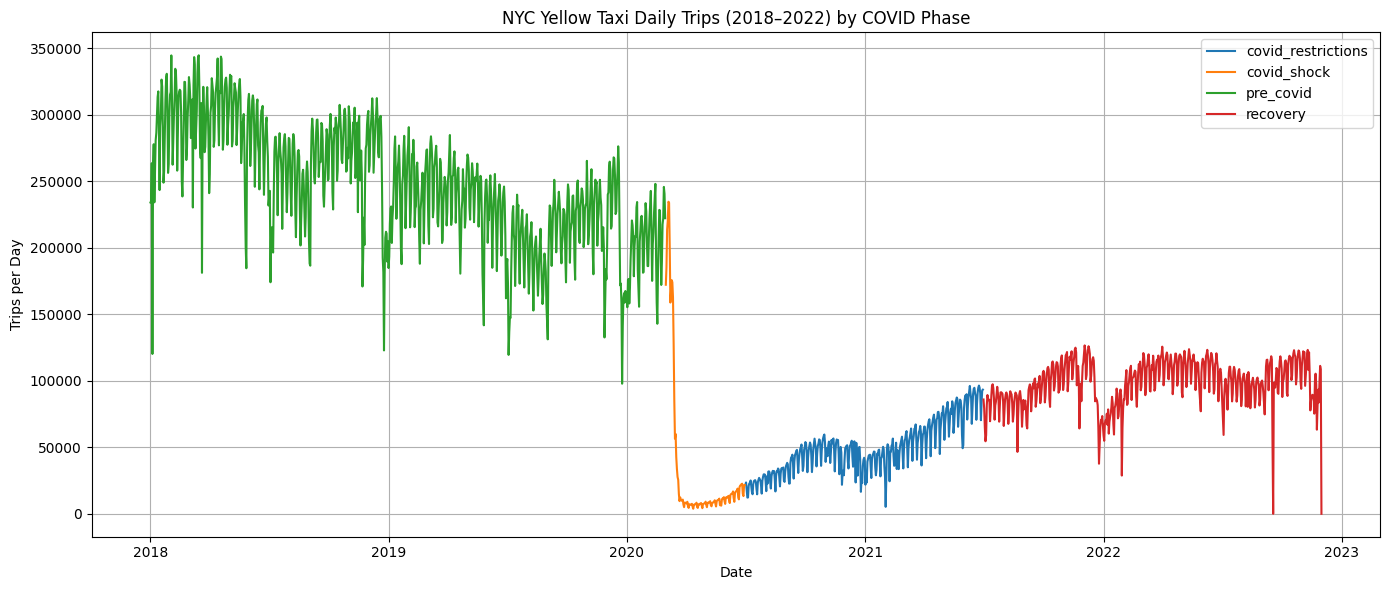

In [15]:
# Plot daily trips by COVID phase

plt.figure(figsize=(14, 6))

for phase in sorted(daily_pd["covid_phase"].unique()):
    subset = daily_pd[daily_pd["covid_phase"] == phase]
    plt.plot(subset["pickup_date"], subset["trips"], label=phase)

plt.title("NYC Yellow Taxi Daily Trips (2018–2022) by COVID Phase")
plt.xlabel("Date")
plt.ylabel("Trips per Day")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

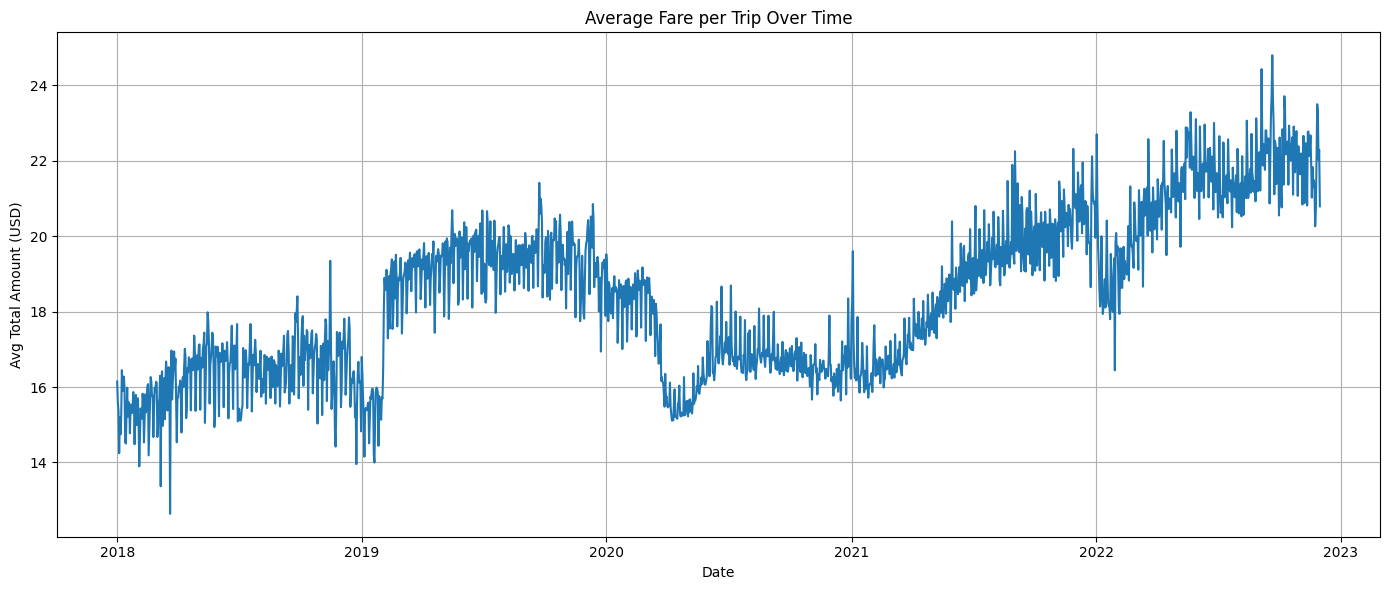

In [16]:
# Plot average total_amount over time

plt.figure(figsize=(14, 6))
plt.plot(daily_pd["pickup_date"], daily_pd["avg_total_amount"])
plt.title("Average Fare per Trip Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Total Amount (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
daily_stats.write.format("bigquery") \
    .option("table", "nyc-taxi-analytics-479702.taxi_analytics.daily_stats") \
    .mode("overwrite") \
    .save()

  0%|           0/475 Tasks

In [18]:
hourly_stats.write.format("bigquery") \
    .option("table", "nyc-taxi-analytics-479702.taxi_analytics.hourly_stats") \
    .mode("overwrite") \
    .save()


  0%|           0/411 Tasks

In [11]:
zone_daily.write.format("bigquery") \
  .option("table", "nyc-taxi-analytics-479702.taxi_analytics.zone_daily_stats") \
    .mode("overwrite") \
    .save()

  0%|           0/323 Tasks

ML Model: Demand Forecasting + Anomaly Detection

In [19]:
# Make sure it's sorted
daily_pd = daily_pd.sort_values("pickup_date")

# Focus on a simpler subset: total trips per day (aggregate over covid_phase)
daily_total = (
    daily_pd.groupby("pickup_date", as_index=False)["trips"].sum()
            .rename(columns={"trips": "total_trips"})
)

daily_total.head()


,pickup_date,total_trips
0,2018-01-01,234025
1,2018-01-02,235155
2,2018-01-03,263570
3,2018-01-04,120199
4,2018-01-05,261822


In [20]:
train = daily_total[daily_total["pickup_date"] < "2022-01-01"].copy()
test  = daily_total[daily_total["pickup_date"] >= "2022-01-01"].copy()


In [21]:
# Baseline forecasting model - scikit-learn (RandomForestRegressor) with calendar features

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def add_time_features(df):
    df = df.copy()
    df["dayofweek"] = df["pickup_date"].dt.dayofweek
    df["month"] = df["pickup_date"].dt.month
    df["year"] = df["pickup_date"].dt.year
    df["dayofyear"] = df["pickup_date"].dt.dayofyear
    return df

train_feat = add_time_features(train)
test_feat  = add_time_features(test)

features = ["dayofweek", "month", "year", "dayofyear"]
X_train = train_feat[features]
y_train = train_feat["total_trips"]
X_test  = test_feat[features]
y_test  = test_feat["total_trips"]

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", mae)


Test MAE: 27927.00032835821


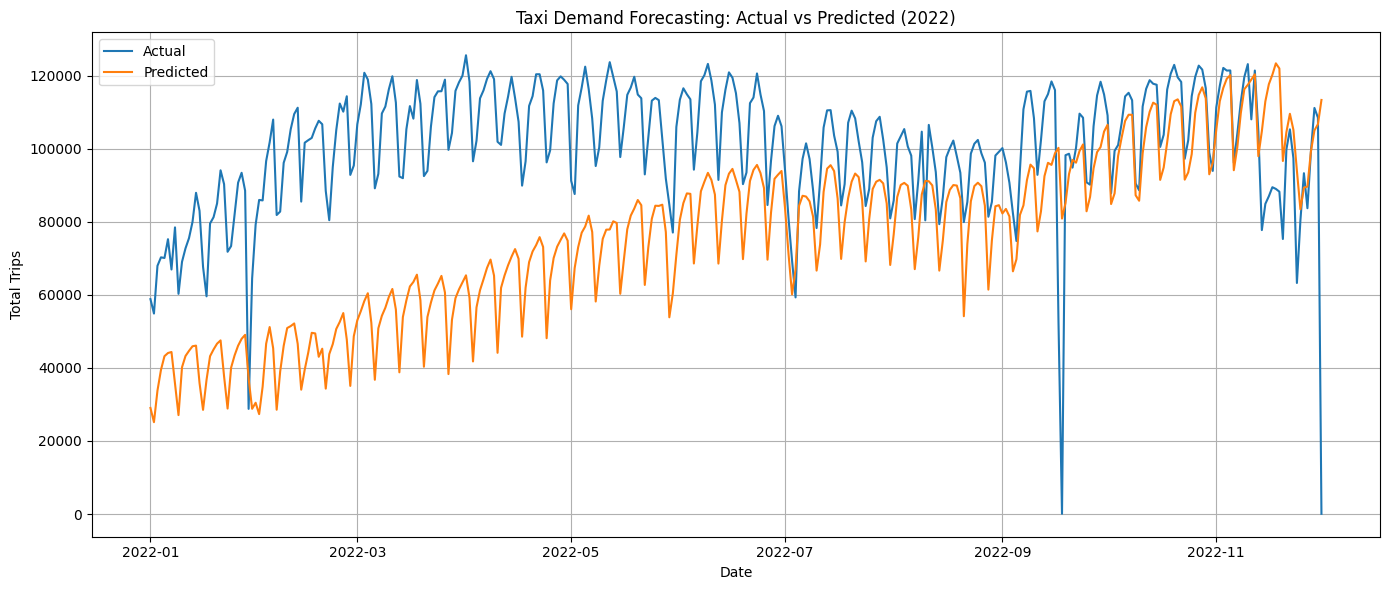

In [22]:
plt.figure(figsize=(14,6))
plt.plot(test_feat["pickup_date"], y_test.values, label="Actual")
plt.plot(test_feat["pickup_date"], y_pred, label="Predicted")
plt.title("Taxi Demand Forecasting: Actual vs Predicted (2022)")
plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


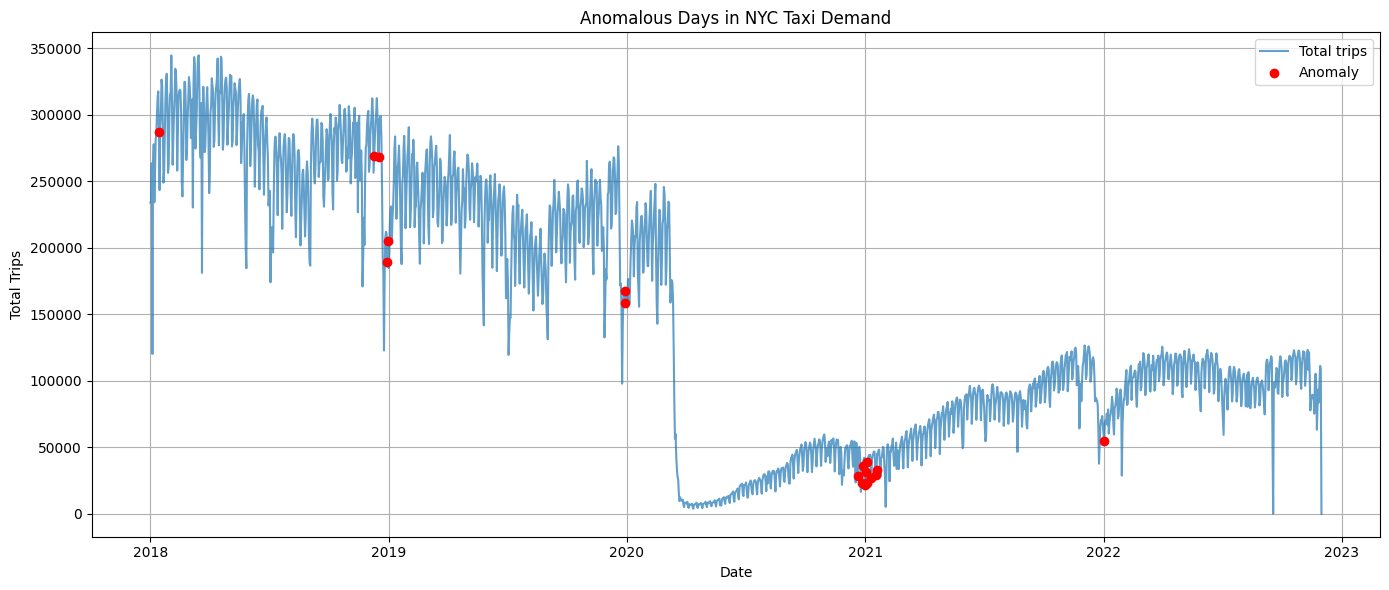

In [23]:
# Detect days where the number of trips is “weird” compared to others

from sklearn.ensemble import IsolationForest

# Use multiple features for anomaly detection
feat_df = add_time_features(daily_total)
X = feat_df[["total_trips", "dayofweek", "month", "dayofyear"]]

iso = IsolationForest(contamination=0.01, random_state=42)
feat_df["anomaly_score"] = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

anomalies = feat_df[feat_df["anomaly_score"] == -1]
anomalies.head()

plt.figure(figsize=(14,6))
plt.plot(feat_df["pickup_date"], feat_df["total_trips"], label="Total trips", alpha=0.7)
plt.scatter(
    anomalies["pickup_date"],
    anomalies["total_trips"],
    color="red",
    label="Anomaly",
    zorder=5
)
plt.title("Anomalous Days in NYC Taxi Demand")
plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
